In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error


In [ ]:
# Generate Synthetic Dataset
np.random.seed(42)

# Date range
dates = pd.date_range(start="2023-01-01", end="2023-10-31")

products = ["P1", "P2", "P3"]
stores = ["S1", "S2"]

data = []

for date in dates:
    for product in products:
        for store in stores:

            base_demand = np.random.randint(10, 30)

            promotion = np.random.choice([0, 1], p=[0.8, 0.2])
            festival = np.random.choice([0, 1], p=[0.9, 0.1])

            demand = base_demand

            if promotion == 1:
                demand += np.random.randint(5, 10)

            if festival == 1:
                demand += np.random.randint(10, 20)

            price = np.random.randint(100, 300)

            data.append([
                date, product, store,
                price, promotion, festival, demand
            ])

df = pd.DataFrame(
    data,
    columns=["date", "product_id", "store_id", "price",
             "promotion", "festival", "sales"]
)

print(df.head())
print("Total rows:", len(df))


        date product_id store_id  price  promotion  festival  sales
0 2023-01-01         P1       S1    171          0         0     16
1 2023-01-01         P1       S2    187          0         0     16
2 2023-01-01         P2       S1    152          0         0     13
3 2023-01-01         P2       S2    291          0         1     22
4 2023-01-01         P3       S1    188          0         0     10
Total rows: 1824


In [ ]:
# Basic Data Understanding
df["date"] = pd.to_datetime(df["date"])

print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1824 non-null   datetime64[ns]
 1   product_id  1824 non-null   object        
 2   store_id    1824 non-null   object        
 3   price       1824 non-null   int64         
 4   promotion   1824 non-null   int64         
 5   festival    1824 non-null   int64         
 6   sales       1824 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 99.9+ KB
None
                      date       price    promotion     festival        sales
count                 1824  1824.00000  1824.000000  1824.000000  1824.000000
mean   2023-06-01 12:00:00   200.33114     0.199561     0.092654    22.189693
min    2023-01-01 00:00:00   100.00000     0.000000     0.000000    10.000000
25%    2023-03-17 18:00:00   151.00000     0.000000     0.000000    16.0000

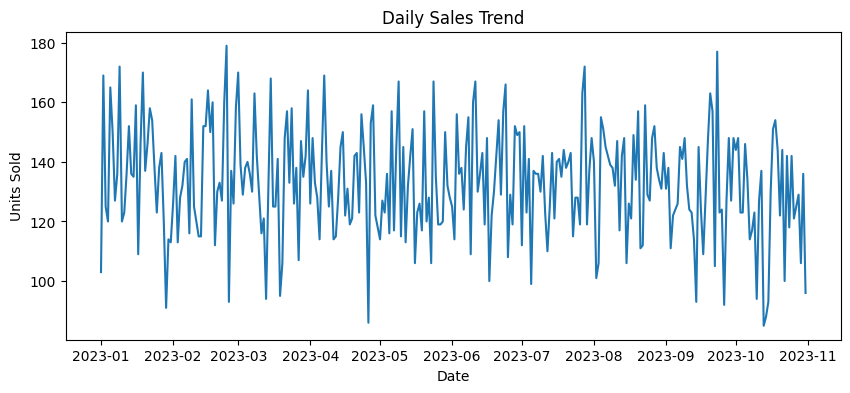

In [ ]:
# Exploratory Data Analysis (EDA)
daily_sales = df.groupby("date")["sales"].sum()

plt.figure(figsize=(10,4))
plt.plot(daily_sales)
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


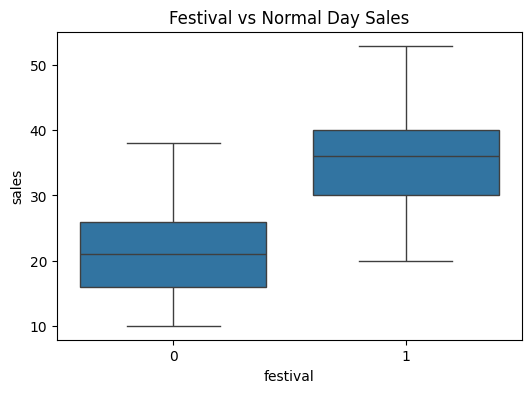

In [ ]:
## Festival vs Normal Day Sales
plt.figure(figsize=(6,4))
sns.boxplot(x="festival", y="sales", data=df)
plt.title("Festival vs Normal Day Sales")
plt.show()


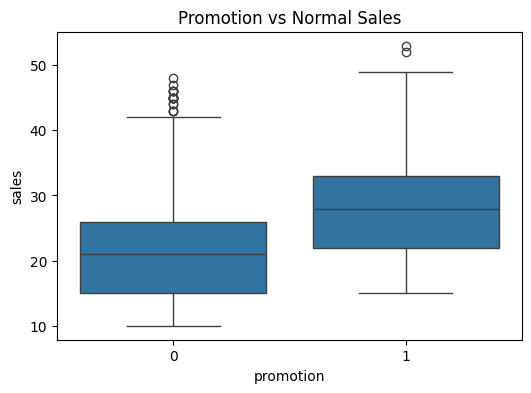

In [ ]:
## Promotion vs Normal Sales
plt.figure(figsize=(6,4))
sns.boxplot(x="promotion", y="sales", data=df)
plt.title("Promotion vs Normal Sales")
plt.show()


In [ ]:
# Time Series Preparation
ts = df.groupby("date")["sales"].sum()


In [ ]:
# Split Data into Train and Test Sets
train = ts[:-30]   # all except last 30 days
test = ts[-30:]    # last 30 days


In [ ]:
# ARIMA Model Training and Forecasting
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)


C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


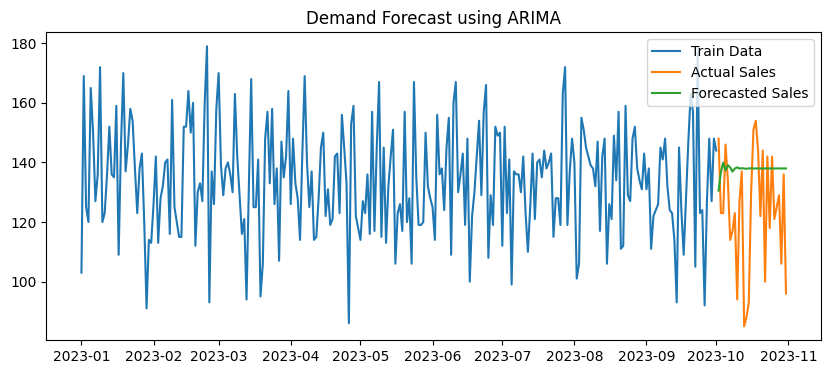

In [ ]:
# Evaluate Forecast
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Actual Sales")
plt.plot(test.index, forecast, label="Forecasted Sales")
plt.legend()
plt.title("Demand Forecast using ARIMA")
plt.show()


In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, forecast)
print("Mean Absolute Error (MAE):", round(mae, 2))


Mean Absolute Error (MAE): 19.05


In [ ]:
# Inventory Metrics Calculation
avg_daily_demand = forecast.mean()

lead_time = 5
safety_stock = avg_daily_demand * 0.2

reorder_point = avg_daily_demand * lead_time + safety_stock

print("Average Daily Demand:", round(avg_daily_demand))
print("Safety Stock:", round(safety_stock))
print("Reorder Point:", round(reorder_point))


Average Daily Demand: 138
Safety Stock: 28
Reorder Point: 716


In [ ]:
# Inventory Decision
current_stock = 300  # assume current inventory

if current_stock < reorder_point:
    print("🔴 Reorder Stock Immediately")
else:
    print("🟢 Stock Level is Sufficient")


🔴 Reorder Stock Immediately


In [ ]:
# Summary of Inventory Metrics
summary = {
    "Average Daily Demand": round(avg_daily_demand),
    "Safety Stock": round(safety_stock),
    "Reorder Point": round(reorder_point),
    "Current Stock": current_stock
}

print(summary)


{'Average Daily Demand': 138, 'Safety Stock': 28, 'Reorder Point': 716, 'Current Stock': 300}


In [ ]:
# Preparing Data for Prophet Model
from prophet import Prophet

prophet_df = df.groupby("date")["sales"].sum().reset_index()
prophet_df.columns = ["ds", "y"]

print(prophet_df.head())


          ds    y
0 2023-01-01  103
1 2023-01-02  169
2 2023-01-03  125
3 2023-01-04  120
4 2023-01-05  165


In [ ]:
# Prophet Model Training
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(prophet_df)


01:33:16 - cmdstanpy - INFO - Chain [1] start processing
01:33:17 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Prophet Forecasting
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
329,2023-11-26,107.292491,85.531059,129.259482
330,2023-11-27,114.306144,92.197684,136.281707
331,2023-11-28,109.621999,88.259761,132.023445
332,2023-11-29,115.632473,93.717564,136.981330
333,2023-11-30,123.137630,100.689042,145.571696


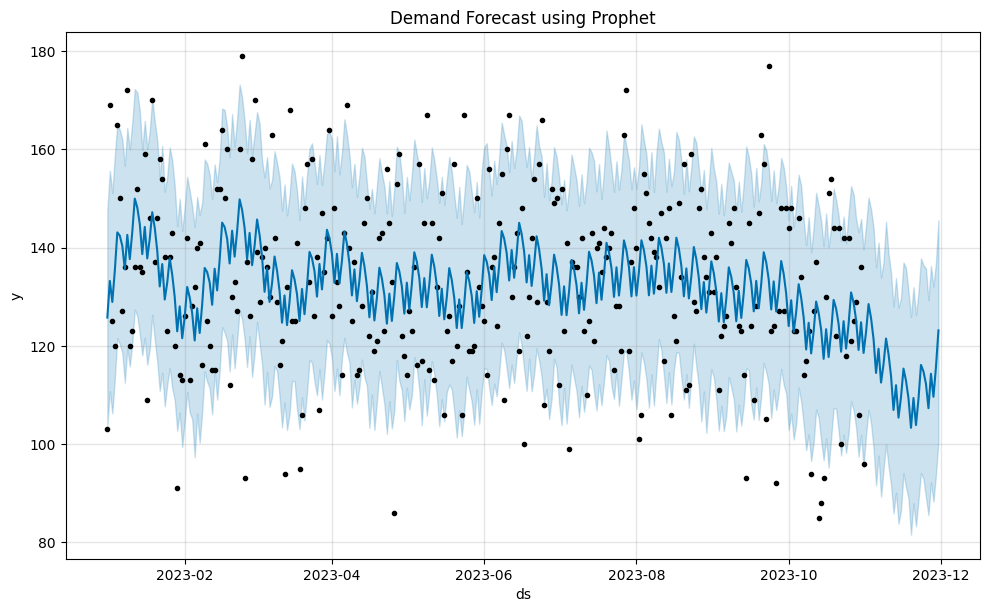

In [ ]:
# Plot Prophet Forecast
model.plot(forecast)
plt.title("Demand Forecast using Prophet")
plt.show()


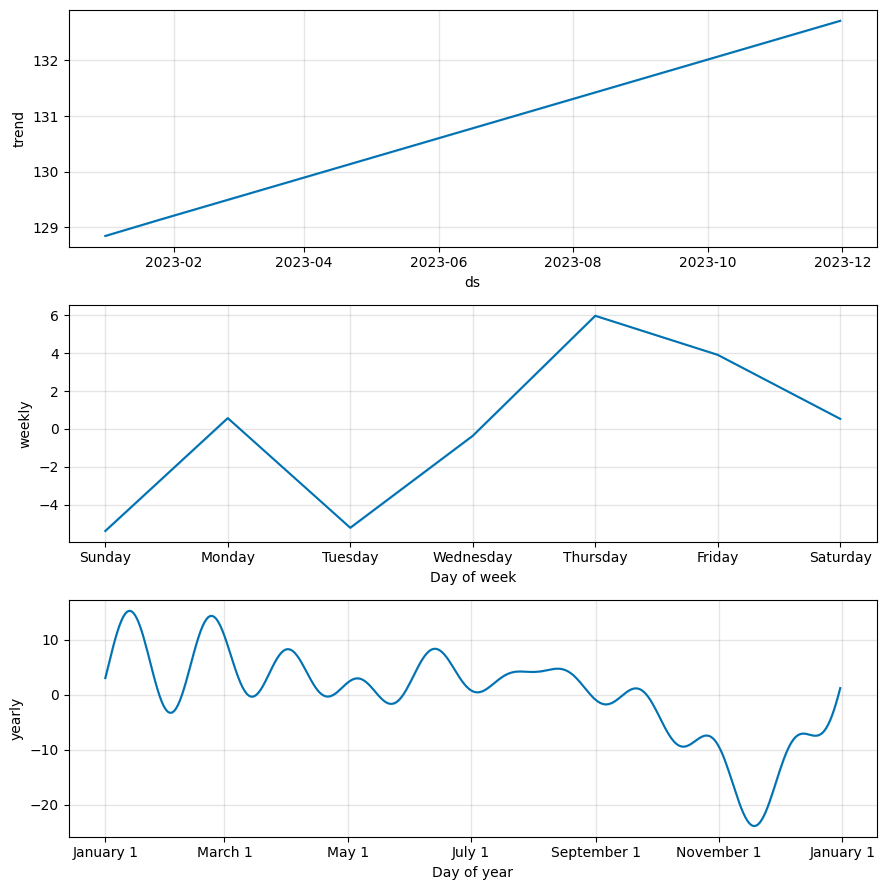

In [ ]:
# Plot Prophet Components
model.plot_components(forecast)
plt.show()


In [ ]:
# Evaluate Prophet Forecast
actual = prophet_df["y"].iloc[-30:]
predicted = forecast["yhat"].iloc[-30:]

mae_prophet = mean_absolute_error(actual, predicted)
print("Prophet MAE:", round(mae_prophet, 2))


Prophet MAE: 18.5


In [ ]:
# Data Normalization Example
from sklearn.preprocessing import MinMaxScaler

ts_values = ts.values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts_values)



In [ ]:
# Create sequences for time series forecasting
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window=30)


In [ ]:
# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# LSTM Model Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LSTM Model Fitting
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.1567 - val_loss: 0.0665
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0504 - val_loss: 0.0485
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0390 - val_loss: 0.0485
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0342 - val_loss: 0.0528
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0362 - val_loss: 0.0489
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0365 - val_loss: 0.0484
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0358 - val_loss: 0.0513
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0337 - val_loss: 0.0486
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0342 - val_loss: 0.0496
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0371 - val_loss: 0.0492
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0335 - val_loss: 0.0484
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0360 - val_loss: 0.0507


In [ ]:
# LSTM Model Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


In [ ]:
# Evaluate LSTM Predictions
mae_lstm = mean_absolute_error(actual, predictions)
print("LSTM MAE:", round(mae_lstm, 2))


LSTM MAE: 16.89


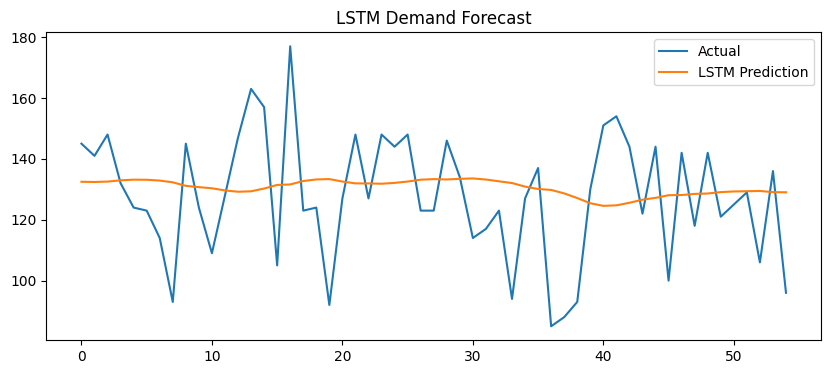

In [ ]:
# Plot LSTM Predictions vs Actual
plt.figure(figsize=(10,4))
plt.plot(actual, label="Actual")
plt.plot(predictions, label="LSTM Prediction")
plt.legend()
plt.title("LSTM Demand Forecast")
plt.show()


In [ ]:
# Final Comparison of MAE
print("ARIMA MAE :", mae)
print("Prophet MAE :", mae_prophet)
print("LSTM MAE :", mae_lstm)


ARIMA MAE : 19.045965779882977
Prophet MAE : 18.500187810196426
LSTM MAE : 16.885231989080257


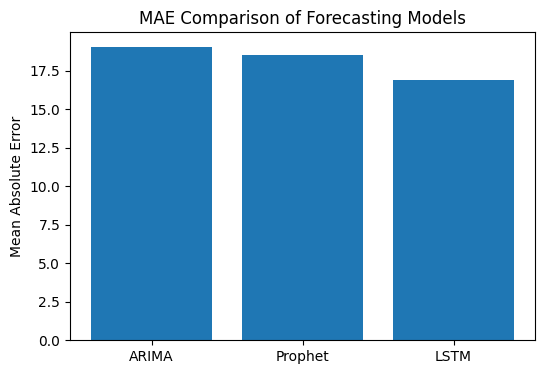

In [ ]:
# Plot Comparison of MAE
models = ["ARIMA", "Prophet", "LSTM"]
errors = [mae, mae_prophet, mae_lstm]

plt.figure(figsize=(6,4))
plt.bar(models, errors)
plt.title("MAE Comparison of Forecasting Models")
plt.ylabel("Mean Absolute Error")
plt.show()


In [ ]:
# Identify Best Model
best_model = models[errors.index(min(errors))]
print("Best Model Based on MAE:", best_model)


Best Model Based on MAE: LSTM
